# Predicting wind energy

Credits: Aurelie Fischer (LPSM)

The two datasets contain the following features.

- P : electrical power

- V : wind speed

- Dir : wind direction in degrees °

- T : temperature


## Your job

- Try to understand the data, visualize it.
- The main aim is then to predict the electrical power produced by the wind turbines.

## We want to see the following things

- Prediction results and error obtained for several machine learning methods for the two wind turbines.
- A discussion about the impact of the hyperparameters of the methods and their calibration on your predictions.
- A clear comparison between your solutions (table, and/or plots comparing the results obtained with different methods).
- Comment about the comparison of both wind turbines.
- A discussion about the difficulties encountered if applicable.
- Aim : best possible predictive performance, in a clean notebook, with clear graphs and explanations.

In [ ]:
#Import packages
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

#Import Scikit packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

#Import package for time measuring
import time

## Useful functions :

We implement some useful functions which will be used in the main program.

In [ ]:
def read_data(fname):
    """
    Receives: a string fname indicating the name of the file
    Returns: a dataframe with the data contained in the file
    """

    #The path containing the notebook
    path_data = './'
    #The name of the file
    filename = fname

    #Import data (except for column names)
    data = pd.read_csv(os.path.join(path_data, filename), sep=" ", skiprows = 1, header = None)

    #Drop first column of observation ids
    data = data.drop(data[[0]], axis = 1)

    #Rename columns
    data = data.rename(columns = {1: "P", 2: "V", 3: "Dir", 4: "T"})

    return data

In [ ]:
def scatter_plot_data(data, name):
    """
    Receives: a dataframe with columns 'P', 'V', 'Dir' and 'T'
    Returns: a 3D scatterplot graph, with color intensity indicating level of 'P'
    """

    #Scatter plot 3D for features (color intensity represents electrical power)
    fig = plt.figure(figsize = (16, 9))
    ax = plt.axes(projection = "3d")

    #Add x, y gridlines
    ax.grid(b = True, color ='grey',
            linestyle ='-.', linewidth = 0.3,
            alpha = 0.2)

    #Create color map
    my_cmap = plt.get_cmap('ocean')

    # Creating plot
    sctt = ax.scatter3D(data['V'], data['Dir'], data['T'],
                        alpha = 0.8,
                        c = data['P'],
                        cmap = my_cmap,
                        marker ='^')

    ax.set_xlabel('V', fontweight ='bold')
    ax.set_ylabel('Dir', fontweight ='bold')
    ax.set_zlabel('T', fontweight ='bold')
    ax.set_title(name)
    fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)

In [ ]:
def plot_pred_data(X, y, T, y_, name):
    """
    Receives: two arrays X and T containing one-dim features, the actual values of y, and predicted y (in y_)
    Returns: a scatterplot (X, y) with a line (T, y_)
    """

    plt.scatter(X, y, color='darkorange', label='data')
    plt.plot(T, y_, color='navy', label='prediction')
    plt.axis('tight')
    plt.legend()
    plt.title(name)

    plt.tight_layout()
    plt.show()

In [ ]:
def prepare_data(data, test_size, random_state):
    """
    Receives: a dataframe, the proportion of data to be used as test, and a random state key
    Returns: scaled (centered and empirical variance set to one) train and test sets
    """

    #Prepare X matrix (drop electrical power)
    X = data.drop(data[['P']], axis = 1)

    #Prepare y vector (electrical power)
    y = data[['P']]

    #Scale data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    y_scaled = scaler.fit_transform(y)

    #Separate X and y into train (60%) and test sets (40%)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size = test_size, random_state = random_state)

    return X_train, X_test, y_train, y_test

In [ ]:
def ml_algorithms(X_train, X_test, y_train, y_test, regressors, names, parameters):
    """
    Receives: train and test sets (dataframes), a list of ML methods, and a dictionary of parameters for each method
    Returns: performance indicators of multiple ML algorithms regressing 'V', 'Dir' and 'T' on 'P';
             and a list of the best models selected by cross validation
    """

    #Initiate regressors
    regressors = regressors
    names = names

    #Set parameters for the grid search
    parameters = parameters

    #List to store models
    models = []

    #Iterate over regressors
    for name, reg, param in zip(names, regressors, parameters):

        #Control time of execution of each method
        start = time.time()

        #Call grid search over previously defined parameters (with cv-fold CV)
        searcher = GridSearchCV(reg, param, cv=5)
        searcher.fit(X_train, np.ravel(y_train))
        end = time.time()

        #Print name of method
        print('Method:', name)

        #Print execution time
        print('Execution time:', end-start, 'seconds')

        #Print best parameters from gridsearch
        print('Selected parameters:', searcher.best_params_)

        #Print score on test datasets
        score = searcher.score(X_test, np.ravel(y_test))
        print('Score:', score)

        #Print RMSE
        y_pred = searcher.predict(X_test)
        rmse_test = mean_squared_error(y_pred, np.ravel(y_test))**(0.5)
        print('RMSE:', rmse_test, '\n')

        #Store model
        models.append(searcher)

    #Return selected models
    return models

## Importing data from text files

First, we import the data contained in the text files for each turbine. They contain approximately 8,700 observations of four physical quantities: electrical power (P), wind speed (V), wind direction in degrees (Dir), and temperature (T).

In [ ]:
#Read preliminary data
data_t1 = read_data('eol1.txt')
data_t2 = read_data('eol2.txt')

#Visualize preliminary data
print('Turbine 1')
display(data_t1.head(n=5))

print('Turbine 2')
display(data_t2.head(n=5))

Turbine 1


,P,V,Dir,T
0,1891.281677,12.025000,176.998334,8.193333
1,1747.884989,11.026667,182.190002,8.171666
2,1427.103353,9.693333,178.459997,8.031667
3,1102.073324,8.533333,180.278336,8.043334
4,1003.248322,8.111667,191.764999,8.235000


Turbine 2


,P,V,Dir,T
0,-2.921667,NaN,79.386665,-2.103333
1,-3.685000,NaN,68.600000,-2.248333
2,-4.170000,NaN,59.245000,-1.996667
3,-2.560000,NaN,71.516668,-1.663333
4,-4.185000,NaN,85.606667,-1.435000


In [ ]:
#Verify number of observations and columns
print('Turbine 1')
print(data_t1.shape, '\n')

print('Turbine 2')
print(data_t2.shape)

Turbine 1
(8616, 4) 

Turbine 2
(8760, 4)


We note that our data import manages to correctly identify the variables as float (more specifically, float64) data type.

In [ ]:
#Verify data type of columns
print('Turbine 1')
print(data_t1.dtypes, '\n')

print('Turbine 2')
print(data_t2.dtypes)

Turbine 1
P      float64
V      float64
Dir    float64
T      float64
dtype: object 

Turbine 2
P      float64
V      float64
Dir    float64
T      float64
dtype: object


From our first dataframe visualization, we were able to identify some NaN observations. We hence decided to investigate all the occasions of null data.

We verify that less than 2% of the observations are NaN. Therefore, we choose to drop them without further investigation. The final (preliminary) dataframes have approximately 8,600 observations each.

In [ ]:
#Verify if there are NaN values
print(data_t1.isnull().sum(), '\n')
print(data_t2.isnull().sum())

P      97
V      97
Dir    98
T      97
dtype: int64 

P       94
V      158
Dir     95
T       94
dtype: int64


In [ ]:
#Drop observations with NaN values
data_t1 = data_t1.dropna()
data_t2 = data_t2.dropna()

print('Turbine 1')
print(data_t1.shape, '\n')

print('Turbine 2')
print(data_t2.shape)

Turbine 1
(8518, 4) 

Turbine 2
(8601, 4)


In [ ]:
#Current state of dataframes
print('Turbine 1')
display(data_t1.head(n=5))

print('Turbine 2')
display(data_t2.head(n=5))

Turbine 1


,P,V,Dir,T
0,1891.281677,12.025000,176.998334,8.193333
1,1747.884989,11.026667,182.190002,8.171666
2,1427.103353,9.693333,178.459997,8.031667
3,1102.073324,8.533333,180.278336,8.043334
4,1003.248322,8.111667,191.764999,8.235000


Turbine 2


,P,V,Dir,T
64,-2.213333,0.000000,310.421666,-0.706667
65,-2.206667,0.318333,329.928335,-1.025000
66,-2.188333,0.461667,344.635005,-1.065000
67,-2.210000,0.271667,233.016668,-1.025000
68,-2.246667,1.058333,323.796661,-1.151667


## Descriptive statistics

We present below some descriptive statistics of the dataframes. This analysis allows us to identify a couple of bizarre observations in our datasets, such as:

* **Electrical Power (P)**: We identify negative values, which may not make sense from a physical standpoint
* **Wind speed (V)**: We identify observations with zero wind speed, which may deserve some further investigation

In [ ]:
#Describe selected statistics of each column
display(data_t1.describe())
display(data_t2.describe())

,P,V,Dir,T
count,8518.000000,8518.000000,8518.000000,8518.000000
mean,478.989094,6.103118,194.913096,11.573433
std,487.242459,2.630240,96.476458,7.418703
min,-8.103333,0.000000,1.513336,-9.248333
25%,97.058333,4.702083,124.882503,5.938333
50%,313.809163,5.985833,203.587502,11.165000
75%,728.518336,7.444583,271.640416,16.916667
max,2049.641663,19.870000,358.838338,34.550001


,P,V,Dir,T
count,8601.000000,8601.000000,8601.000000,8601.000000
mean,355.923053,5.243939,171.399482,12.355480
std,450.599555,2.514005,85.846771,7.186671
min,-8.623333,0.000000,2.571667,-6.013333
25%,24.165000,3.630000,95.840000,6.980000
50%,177.329999,5.138333,189.451668,12.751667
75%,510.220001,6.495000,233.308332,17.603333
max,2042.544963,19.923333,358.385005,34.856667


We focus our investigation on the Turbine 1, as the other will be analogous. We observe almost 1,000 rows with negative electrical power, which we choose to abandon as we cannot find a physical explanation.

Concerning wind velocity, we observe only ~60 rows with zero observations. They seem to be positively correlated with the negative electricity power measurements. We hence opt to drop them as well.

In [ ]:
#Subset observations with negative electrical power
print(data_t1[data_t1['P'] <= 0])

             P         V         Dir          T
81   -4.710000  5.361667  262.784996   9.813333
131  -1.951667  1.401667  233.655001   9.351667
134  -1.955000  1.795000  276.603343   9.490000
135  -2.066667  2.151667  276.388326   9.435000
136  -1.371667  2.246667  245.066668   9.498333
...        ...       ...         ...        ...
8122 -4.098333  4.675000  125.166669   3.571667
8125 -2.326667  3.186667  128.173336   6.155000
8318 -1.446667  2.736667  244.218328  10.565000
8521 -2.011667  2.090000  239.708336   8.543334
8523 -1.833333  1.953333  297.356674   7.998333

[945 rows x 4 columns]


In [ ]:
#Subset observations with zero wind speed
print(data_t1[data_t1['V'] <= 0])

             P    V         Dir         T
222  -1.260000  0.0  204.478333  6.525000
501  -1.323333  0.0  199.831662  0.895000
937  -1.320000  0.0   43.598332  1.545000
1118 -1.258333  0.0   64.638333  5.665000
1119 -1.263333  0.0   77.563334  5.846667
...        ...  ...         ...       ...
7793 -1.288333  0.0  176.346673  5.946667
7794 -1.306667  0.0  225.958327  5.561667
7795 -1.338333  0.0   83.366667  5.283333
7796 -1.413333  0.0  101.985002  5.190000
7934 -1.295000  0.0  262.634997  6.050000

[61 rows x 4 columns]


In [ ]:
#Drop observations with negative electrical power and with zero wind speed
data_t1 = data_t1[(data_t1['P'] > 0) & (data_t1['V'] > 0)]
data_t2 = data_t2[(data_t2['P'] > 0) & (data_t2['V'] > 0)]

#Final dataframes
print('Turbine 1')
display(data_t1.head(n=5))

print('Turbine 2')
display(data_t2.head(n=5))

Turbine 1


,P,V,Dir,T
0,1891.281677,12.025000,176.998334,8.193333
1,1747.884989,11.026667,182.190002,8.171666
2,1427.103353,9.693333,178.459997,8.031667
3,1102.073324,8.533333,180.278336,8.043334
4,1003.248322,8.111667,191.764999,8.235000


Turbine 2


,P,V,Dir,T
89,49.610001,4.300000,146.493332,-4.826667
90,39.531667,4.478333,150.364998,-4.825000
91,37.271666,4.150000,136.670003,-4.808333
92,22.001666,3.773333,136.410001,-4.965000
93,43.658334,4.236667,116.906667,-5.468333


#### Scatterplot

We plot a 3D-scatterplot of the three features V, Dir and T, with the color scale indicating the level of electricity power. Although the chart may be considered beautiful, it is not easy to draw conclusions...

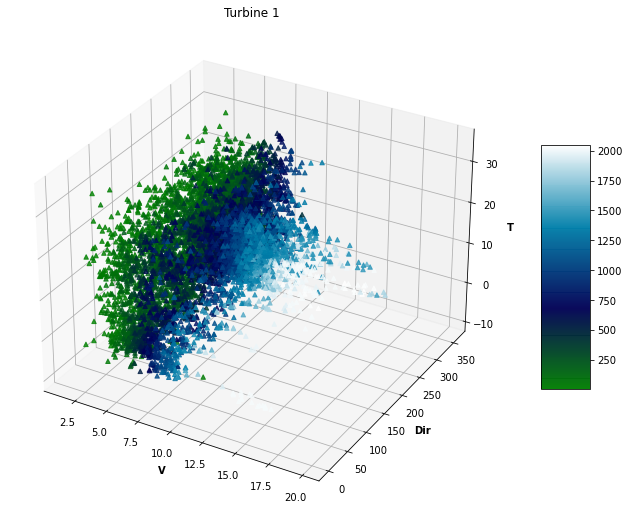

In [ ]:
#Display 3D scatter plots with color intensity indicating power generation
scatter_plot_data(data_t1, 'Turbine 1')

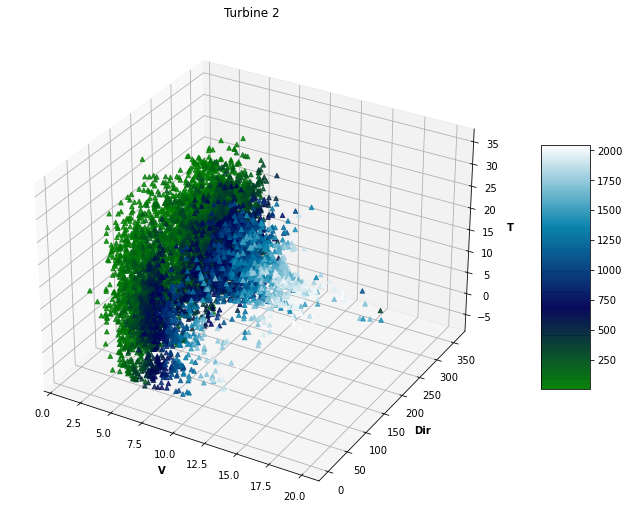

In [ ]:
scatter_plot_data(data_t2, 'Turbine 2')

#### Pairplot: scatterplot 2-by-2

In the charts below, we use histograms to observe the distribution of each one of the variables in our dataframes (charts in the diagonal) and we also plot the 2-by-2 scatterplots, which allows us to visualize their correlation level.

There are three things that caught our attention at a first glance:

1. The **weak correlation between electricity power (P) and wind direction (Dir) and temperature (T)** in both turbines
2. On the other hand, a **strong correlation between electricity power (P) and wind speed (V)** in both turbines
3. The **'bifurcation' in the scatterplot V x P for high P which takes place in the first turbine but not in the second**. A possible explanation would be that during a certain period power production was capped for engineering reasons (so even with strong wind, the production would not pass a certain level)

Turbine 1


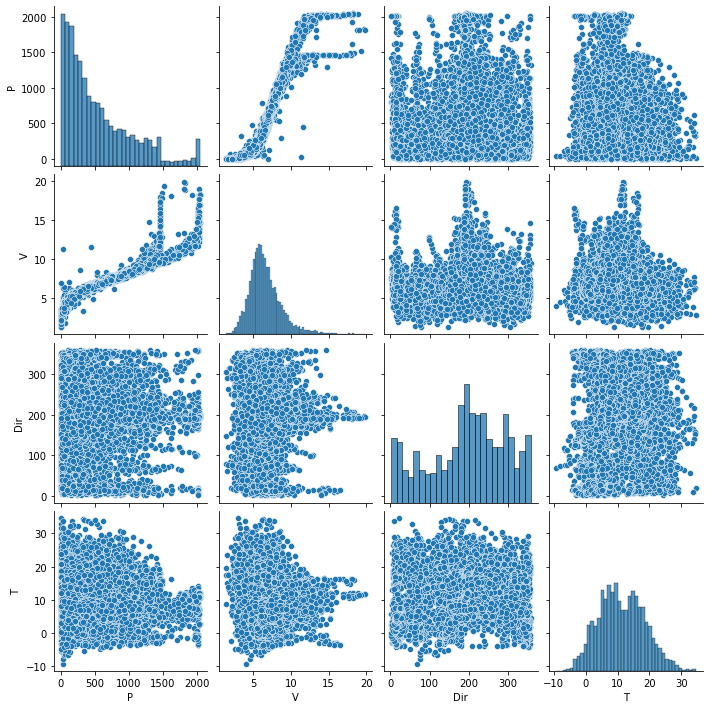

In [ ]:
#Scatterplots of columns two-by-two
print('Turbine 1')
sns.pairplot(data_t1[['P', 'V', 'Dir', 'T']], diag_kind="hist")

Turbine 2


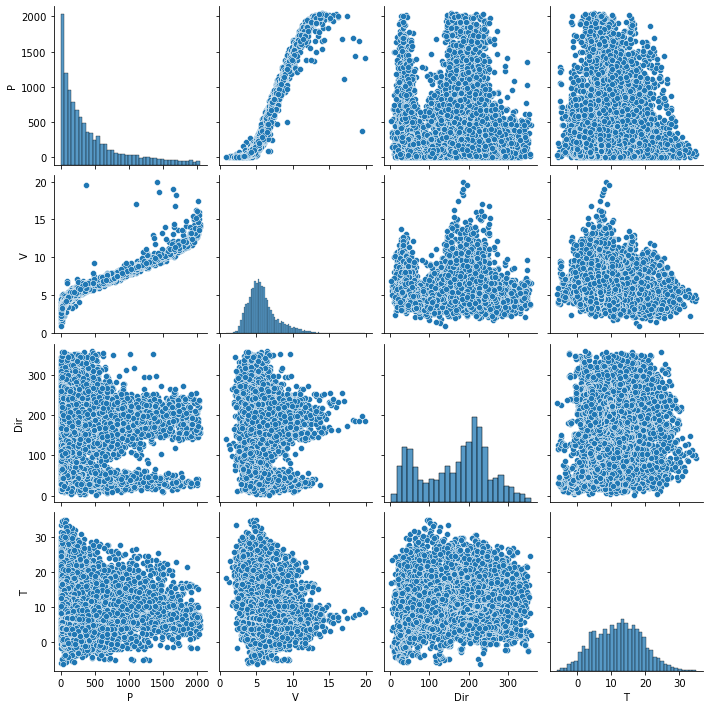

In [ ]:
print('Turbine 2')
sns.pairplot(data_t2[['P', 'V', 'Dir', 'T']], diag_kind="hist")

We also find it useful to present the correlation matrix for the variables, justifying numerically our previous discussion. We see that features are weakly correlated between them, which is a positive for the regression models which will be further implemented.

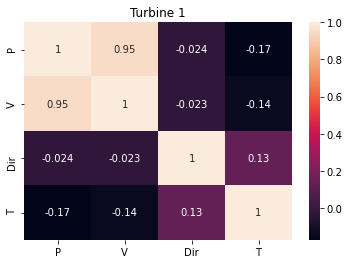

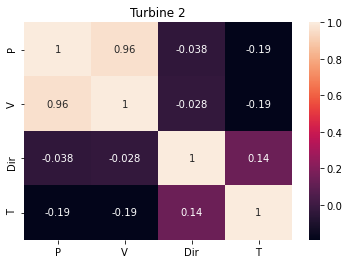

In [ ]:
#Correlation matrix between regressors
corrMatrix = data_t1.corr()
sns.heatmap(corrMatrix, annot=True)
plt.title('Turbine 1')
plt.show()

corrMatrix = data_t2.corr()
sns.heatmap(corrMatrix, annot=True)
plt.title('Turbine 2')
plt.show()

## Finally, some Machine Learning

In this section, we implement Machine Learning algorithms to regress V, Dir and T on P. We compare their predictive performance on a test set, not used in the training process. This is how we proceed (for more details, see the implemented function in the Functions section):

1. Divide features and electricity power in train and test sets
2. Select a list of ML methods and a list of hyperparameters
3. Train the model on the training set using cross-validation to choose the best hyperparameters
4. Test the model on the test set

The main performance metric used in this project is the empirical test set RMSE. Matematically, let $n_{(t)}$ be the number of observations in the test set, $y_{i}^{(t)}$ the actual values of electricity power in the test set, and $\hat{y}_{i}^{(t)}$ the predicted values of the model selected by cross-validation, we have:

$$RMSE = \sqrt{\frac{\sum_{i=0}^{n_{(t)}}(y_{i}^{(t)}-\hat{y}_{i}^{(t)})^{2}}{n_{(t)}}}$$

We also present the score of each method and its execution time, as we believe the latter is an important decision variable especially for massive data (which is not the case here though).

**The choice of the methods to be tested was discritionary (based on what we have seen in the course), as well as the choice of the hyperparameters to be tuned. Some hyperparameters were not included in the gridsearch due to being too time consuming (for instance, experimenting with new kernels for SVR).**

In [ ]:
#Run ML algorithms for regression (for further details, please see the code of the function)

#Initiate regressors
regressors = [
    LinearRegression(),
    KNeighborsRegressor(),
    RandomForestRegressor(),
    AdaBoostRegressor(),
    SVR(),
    DecisionTreeRegressor()
]

names = [
    'Linear Regression',
    'k-Nearest Neighbors',
    'Random Forest',
    'Adaboost',
    'Support Vector Regressor',
    'Decision Tree Regressor'
]

#Set parameters for the grid search
parameters = [
    {},
    {'n_neighbors':np.arange(1, 30), 'weights':['uniform', 'distance'], 'p': [1, 2]},
    {'n_estimators':np.arange(50, 200, 50), 'max_features':['auto', 'sqrt', 'log2']},
    {'n_estimators':np.arange(20, 100, 20), 'loss':['linear', 'square', 'exponential']},
    {'C':np.logspace(-3, 2, 5)},
    {'max_depth':np.arange(1, 20)}
]

### Performance metrics of the selected models

#### Turbine 1

In [ ]:
#Prepare data for Turbine 1
X_train, X_test, y_train, y_test = prepare_data(data_t1, 0.4, 12)

#ML methods for regression for Turbine 1
print('Turbine 1 \n')
results_t1 = ml_algorithms(X_train, X_test, y_train, y_test, regressors, names, parameters)

Turbine 1 

Method: Linear Regression
Execution time: 0.014761924743652344 seconds
Selected parameters: {}
Score: 0.9163194959811943
RMSE: 0.2927894784337222 

Method: k-Nearest Neighbors
Execution time: 7.051624298095703 seconds
Selected parameters: {'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
Score: 0.9829850950732747
RMSE: 0.1320255805105193 

Method: Random Forest
Execution time: 39.48130178451538 seconds
Selected parameters: {'max_features': 'auto', 'n_estimators': 150}
Score: 0.9845672650564621
RMSE: 0.1257374854765454 

Method: Adaboost
Execution time: 14.657421588897705 seconds
Selected parameters: {'loss': 'square', 'n_estimators': 40}
Score: 0.9653406955671382
RMSE: 0.1884313865026677 

Method: Support Vector Regressor
Execution time: 32.35158705711365 seconds
Selected parameters: {'C': 5.623413251903491}
Score: 0.9850006881785789
RMSE: 0.12395926407843186 

Method: Decision Tree Regressor
Execution time: 1.1041796207427979 seconds
Selected parameters: {'max_depth': 5}


#### Histogram of prediction errors on the test sets

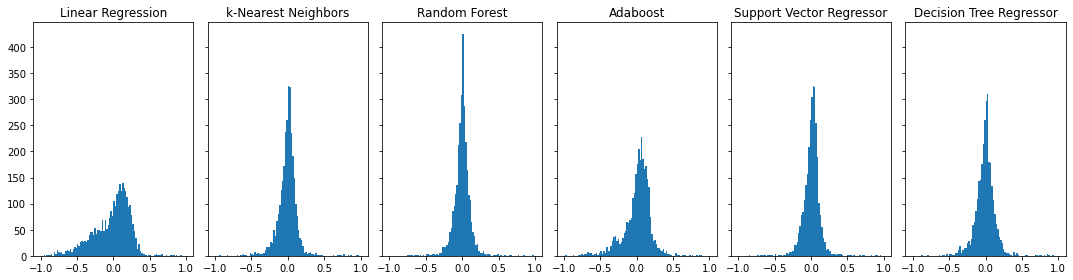

In [ ]:
#Histogram of prediction errors on test sets for selected models
fig, axs = plt.subplots(1, len(names), sharey=True, tight_layout=True, figsize=(15,4))
n_bins = 100

for i, name in enumerate(names):

    #Compute prediction errors on test sets
    y_pred = results_t1[i].predict(X_test)
    error = y_pred - np.ravel(y_test)

    #Display histogram
    axs[i].hist(error, bins=n_bins, range=(-1,1))
    axs[i].set_title(name)

#### Turbine 2

In [ ]:
#Prepare data for Turbine 2
X_train, X_test, y_train, y_test = prepare_data(data_t2, 0.4, 12)

#ML methods for regression for Turbine 1
print('Turbine 2 \n')
results_t2 = ml_algorithms(X_train, X_test, y_train, y_test, regressors, names, parameters)

Turbine 2 

Method: Linear Regression
Execution time: 0.014960050582885742 seconds
Selected parameters: {}
Score: 0.9211415408038653
RMSE: 0.2808016180703509 

Method: k-Nearest Neighbors
Execution time: 8.337067365646362 seconds
Selected parameters: {'n_neighbors': 11, 'p': 2, 'weights': 'distance'}
Score: 0.9860865193036248
RMSE: 0.11794875397783393 

Method: Random Forest
Execution time: 38.454681396484375 seconds
Selected parameters: {'max_features': 'auto', 'n_estimators': 150}
Score: 0.9878320219745653
RMSE: 0.11030232601472997 

Method: Adaboost
Execution time: 11.869781255722046 seconds
Selected parameters: {'loss': 'linear', 'n_estimators': 20}
Score: 0.9705827805616308
RMSE: 0.1715047972705337 

Method: Support Vector Regressor
Execution time: 26.990934371948242 seconds
Selected parameters: {'C': 5.623413251903491}
Score: 0.9889970469770876
RMSE: 0.1048890354702077 

Method: Decision Tree Regressor
Execution time: 0.9629504680633545 seconds
Selected parameters: {'max_depth': 

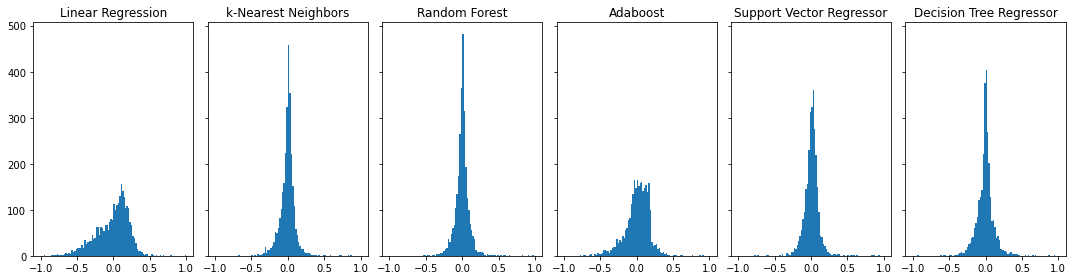

In [ ]:
#Histogram of prediction errors on test sets for selected models
fig, axs = plt.subplots(1, len(names), sharey=True, tight_layout=True, figsize=(15,4))
n_bins = 100

for i, name in enumerate(names):

    #Compute prediction errors on test sets
    y_pred = results_t2[i].predict(X_test)
    error = y_pred - np.ravel(y_test)

    #Display histogram
    axs[i].hist(error, bins=n_bins, range=(-1,1))
    axs[i].set_title(name)

## Some discussion on the hyperparameters

As we have extensively discussed in class, the choice of the hyperparameters is an important task in Machine Learning. In our previous computations, the choice of the optimal value for these special parameters were made by five-fold cross-validation.

In this section, we choose two specific models, Decision Tree and k-Nearest Neighbors, to show how the train-RMSE and test-RMSE behave.

#### Tree

For the **Tree** method, we obtain train and test RMSE curves very similar to the ones presented in the course as 'the expected behaviour'. As expected, the training error diminishes as we provide more flexibility for the method (through increasing the maximum depth of the trees). The test error, however, finds a minimum around 3 and then starts increasing. This shows the importance of cross-validating the method in a separated data set.

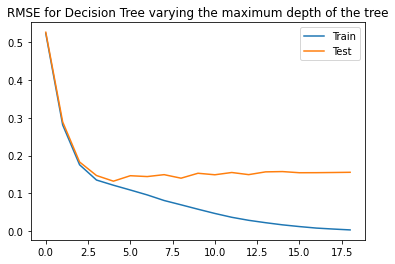

In [ ]:
#Impact of hyperparameters in Tree
score_train = []
score_test = []

for max_depth in np.arange(1, 20):

    #Initialize knn regression with different number of neighbours
    reg = DecisionTreeRegressor(max_depth = max_depth)

    #Fit regression
    reg.fit(X_train, np.ravel(y_train))

    #RMSE for train set
    y_pred = reg.predict(X_train)
    rmse_train = mean_squared_error(y_pred, np.ravel(y_train))**(0.5)
    score_train.append(rmse_train)

    #RMSE for test set
    y_pred = reg.predict(X_test)
    rmse_test = mean_squared_error(y_pred, np.ravel(y_test))**(0.5)
    score_test.append(rmse_test)

#Plot each series
plt.plot(score_train)
plt.plot(score_test)

#Display plot
plt.title('RMSE for Decision Tree varying the maximum depth of the tree')
plt.legend(['Train', 'Test'])
plt.show()

#### k-NN

For the **K-Neighbors** method, we obtain a more interesting behavior for the error curves. As we increase the number of neighbors, we see the train errors getting higher, while test errors decrease. This implies a certain trade-off to choose the optimal number of neighbors.

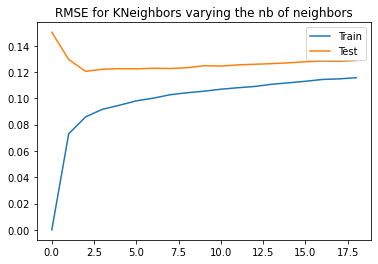

In [ ]:
#Impact of hyperparameters in k-NN
score_train = []
score_test = []

for k in np.arange(1, 20):

    #Initialize knn regression with different number of neighbours
    reg = KNeighborsRegressor(n_neighbors = k)

    #Fit regression
    reg.fit(X_train, np.ravel(y_train))

    #RMSE for train set
    y_pred = reg.predict(X_train)
    rmse_train = mean_squared_error(y_pred, np.ravel(y_train))**(0.5)
    score_train.append(rmse_train)

    #RMSE for test set
    y_pred = reg.predict(X_test)
    rmse_test = mean_squared_error(y_pred, np.ravel(y_test))**(0.5)
    score_test.append(rmse_test)

#Plot each series
plt.plot(score_train)
plt.plot(score_test)

#Display plot
plt.title('RMSE for KNeighbors varying the nb of neighbors')
plt.legend(['Train', 'Test'])
plt.show()

## Simplifying the model

As we saw in the previous sections, the correlation between power production and wind speed is much higher compared with the other variables. In this case, we can try to re-apply Machine Learning regressors considering only this sole feature, which allows us to better visualize how our predictions compare to the actual data. We will also check whether we lose or not predictive power remaining with only one feature.

**OBS**: I know that this is not a very strong argument for dropping temperature and wind direction, since correlation is a measure of 'linear alignement', and, of course, other kind of dependencies can still take place. The idea here is just simplify the model to facilitate visualization.

In [ ]:
#Prepare data for Turbine 1
data_t1_simp = data_t1.drop(data_t1[['Dir', 'T']], axis = 1)
X_train, X_test, y_train, y_test = prepare_data(data_t1_simp, 0.4, 12)

#ML methods for regression for Turbine 1
print('Turbine 1 \n')
results_t1_simple = ml_algorithms(X_train, X_test, y_train, y_test, regressors, names, parameters)

Turbine 1 

Method: Linear Regression
Execution time: 0.007978200912475586 seconds
Selected parameters: {}
Score: 0.914825762662985
RMSE: 0.2953911292763144 

Method: k-Nearest Neighbors
Execution time: 4.860771656036377 seconds
Selected parameters: {'n_neighbors': 29, 'p': 1, 'weights': 'uniform'}
Score: 0.9758963848300055
RMSE: 0.15713915550033758 

Method: Random Forest
Execution time: 25.56697368621826 seconds
Selected parameters: {'max_features': 'log2', 'n_estimators': 100}
Score: 0.9669743080401307
RMSE: 0.1839370789309717 

Method: Adaboost
Execution time: 4.1791090965271 seconds
Selected parameters: {'loss': 'linear', 'n_estimators': 40}
Score: 0.9596099457828271
RMSE: 0.20341385968850753 

Method: Support Vector Regressor
Execution time: 18.039031267166138 seconds
Selected parameters: {'C': 5.623413251903491}
Score: 0.9766407828238737
RMSE: 0.15469364209505976 

Method: Decision Tree Regressor
Execution time: 0.4802591800689697 seconds
Selected parameters: {'max_depth': 5}
Sc

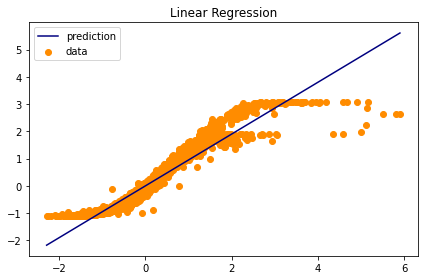

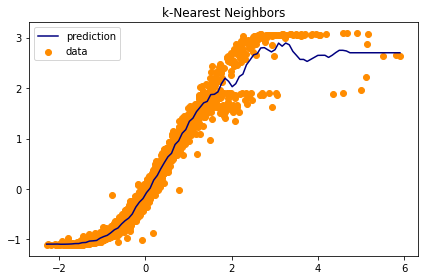

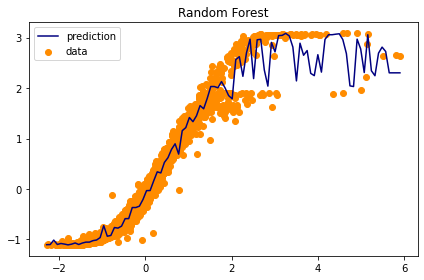

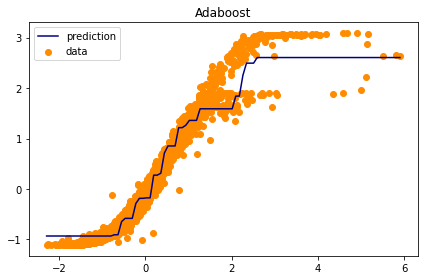

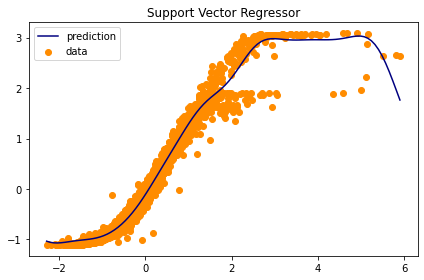

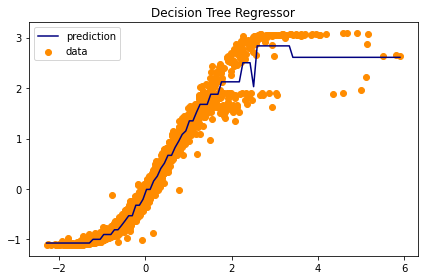

In [ ]:
#Plot predicted power for each method vs actual values in the test set
for i, name in enumerate(names):

    #Compute prediction errors on test sets
    T = np.linspace(min(X_test), max(X_test), 100)
    y_pred = results_t1_simple[i].predict(T)
    y_actual = np.ravel(y_test)

    plot_pred_data(X_test, y_actual, T, y_pred, name)

In [ ]:
#Prepare data for Turbine 2
data_t2_simp = data_t2.drop(data_t2[['Dir', 'T']], axis = 1)
X_train, X_test, y_train, y_test = prepare_data(data_t2_simp, 0.4, 12)

#ML methods for regression for Turbine 1
print('Turbine 2 \n')
results_t2_simple = ml_algorithms(X_train, X_test, y_train, y_test, regressors, names, parameters)

Turbine 2 

Method: Linear Regression
Execution time: 0.012964963912963867 seconds
Selected parameters: {}
Score: 0.9209437422106096
RMSE: 0.2811535611623086 

Method: k-Nearest Neighbors
Execution time: 3.6790826320648193 seconds
Selected parameters: {'n_neighbors': 28, 'p': 1, 'weights': 'uniform'}
Score: 0.9816345238021777
RMSE: 0.1355116268822508 

Method: Random Forest
Execution time: 23.97887682914734 seconds
Selected parameters: {'max_features': 'sqrt', 'n_estimators': 50}
Score: 0.9769378751993877
RMSE: 0.15185361020661636 

Method: Adaboost
Execution time: 8.00452184677124 seconds
Selected parameters: {'loss': 'linear', 'n_estimators': 20}
Score: 0.9683324879084498
RMSE: 0.17794362554409218 

Method: Support Vector Regressor
Execution time: 13.735938310623169 seconds
Selected parameters: {'C': 0.31622776601683794}
Score: 0.983716351390937
RMSE: 0.12760019069063644 

Method: Decision Tree Regressor
Execution time: 0.4148900508880615 seconds
Selected parameters: {'max_depth': 5}

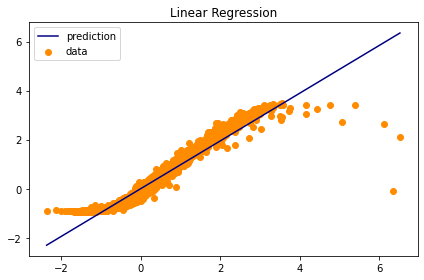

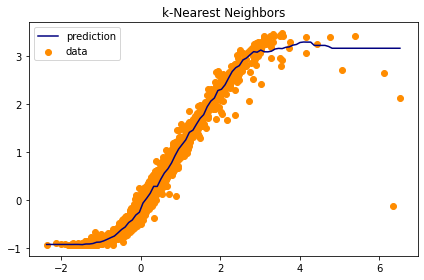

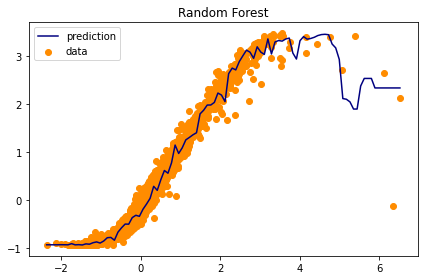

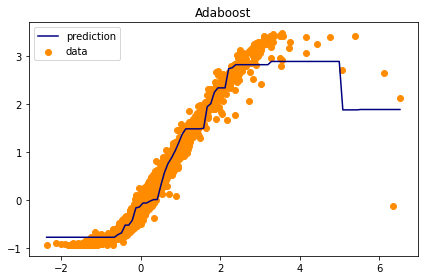

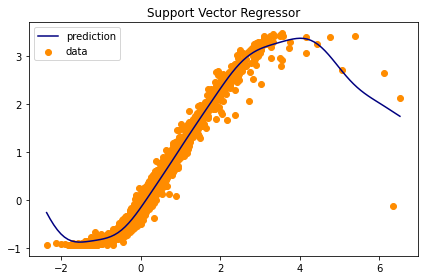

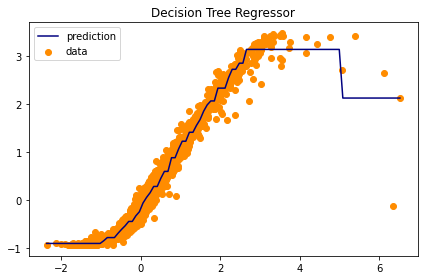

In [ ]:
#Plot predicted power for each method vs actual values in the test set
for i, name in enumerate(names):

    #Compute prediction errors on test sets
    T = np.linspace(min(X_test), max(X_test), 100)
    y_pred = results_t2_simple[i].predict(T)
    y_actual = np.ravel(y_test)

    plot_pred_data(X_test, y_actual, T, y_pred, name)

## Conclusion

We summarize the main insights of our project.

1. For both turbines, the methods **Random Forest and SVR were the ones with the smallest RMSE in the test set**.

2. On the other hand, **they were the most time consuming algorithms**

3. Looking at the power prediction values in the simplified model, we see that **SVR presents a much more smooth curve**, specially for the higher electricity powers. We conjecture that this comes from the fact that the variance of electricity power tends to augment for higher values in our data set due to the bizarre behaviour of 'bifurcation' that we observed in the first section of this report. We believe that this could be used as an argument to choose the SVR.

4. **Although wind direction and temperature do not present a significant correlation with electricity power, they contribute to a reasonable decrease in the test RMSE** of our chosen methods. For instance, for SVR in Turbine 1, the RMSE with all features is ~0.12 while ~0.15 if we only consider wind speed.

Therefore, we would recommend to use the SVR as a predictive tool for electricity power. We recall the performance metrics of the select model (by cross-validation in the test set):

*Method: Support Vector Regressor /
Execution time: 37 seconds /
Selected parameters: {'C': 5.62} /
Score: 0.985 /
RMSE: 0.124*

*Method: Support Vector Regressor /
Execution time: 24 seconds /
Selected parameters: {'C': 5.62} /
Score: 0.989 /
RMSE: 0.105*